## Install and Import Required Libraries

In [1]:
import json
import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from typing import List, Tuple, Dict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from tqdm.auto import tqdm

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Load and Explore Data

In [2]:
def load_jsonl(filepath: str) -> List[Dict]:
    """Load data from JSONL file"""
    data = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line.strip()))
    return data

data = load_jsonl('/kaggle/input/time-complexity-dataset-python-codes/data.jsonl')
print(f"Total samples: {len(data)}")

df = pd.DataFrame(data)
df.head()

Total samples: 40030


,id,language,code,time_complexity,complexity_class
0,009514,python,def ilog2_mtfjvt(n):\n if n <= 0:\n ...,O(log n),1
1,037294,python,"def n2logn_ytvjla(arr_kpytvm, x):\n a = sor...",other complexity,5
2,032631,python,def count_inversions_inblzo(arr_itjyxm):\n ...,O(n²),4
3,038512,python,"def knap_bmunqi(w, v, cap, i=0):\n if i == ...",other complexity,5
4,035526,python,def is_prime_sqrt_sruedh(n):\n if n < 2:\n ...,other complexity,5


Class Distribution:
complexity_class
0    6672
1    6672
2    6672
3    6672
4    6671
5    6671
Name: count, dtype: int64


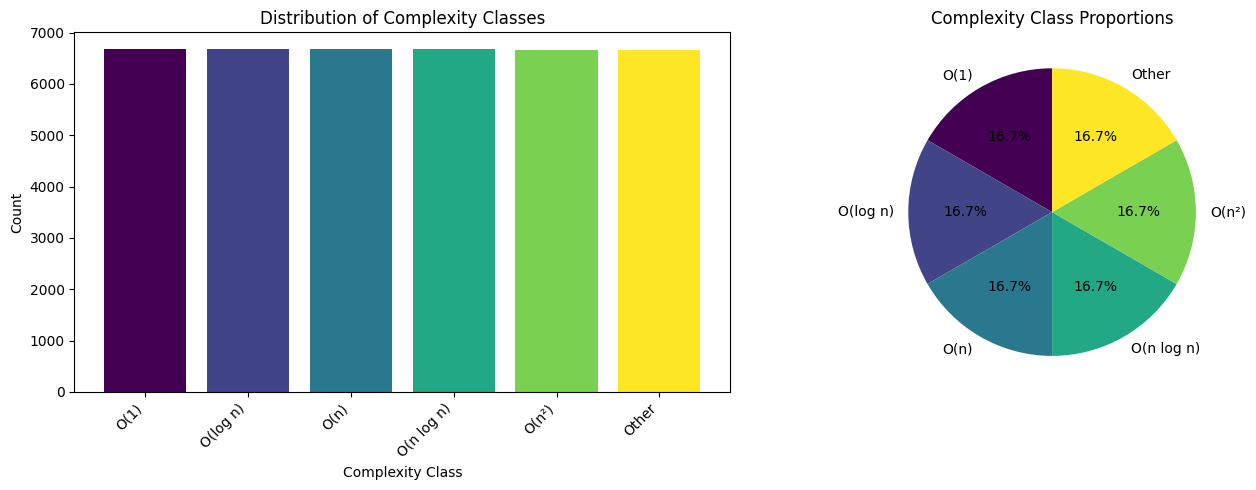


Code Length Statistics:
count    40030.000000
mean       167.507894
std         97.740953
min         29.000000
25%         96.000000
50%        125.000000
75%        223.000000
max        457.000000
Name: code_length, dtype: float64


In [3]:
complexity_labels = {
    0: 'O(1)',
    1: 'O(log n)',
    2: 'O(n)',
    3: 'O(n log n)',
    4: 'O(n²)',
    5: 'Other'
}

print("Class Distribution:")
print(df['complexity_class'].value_counts().sort_index())

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

class_counts = df['complexity_class'].value_counts().sort_index()
colors = plt.cm.viridis(np.linspace(0, 1, len(class_counts)))
bars = axes[0].bar(class_counts.index, class_counts.values, color=colors)
axes[0].set_xlabel('Complexity Class')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Complexity Classes')
axes[0].set_xticks(range(6))
axes[0].set_xticklabels([complexity_labels[i] for i in range(6)], rotation=45, ha='right')

axes[1].pie(class_counts.values, labels=[complexity_labels[i] for i in class_counts.index], 
            autopct='%1.1f%%', colors=colors, startangle=90)
axes[1].set_title('Complexity Class Proportions')

plt.tight_layout()
plt.show()

df['code_length'] = df['code'].apply(len)
print(f"\nCode Length Statistics:")
print(df['code_length'].describe())

## Code Tokenization


In [4]:
class PythonCodeTokenizer:
    """Custom tokenizer for Python code"""
    
    # Python keywords
    KEYWORDS = {
        'False', 'None', 'True', 'and', 'as', 'assert', 'async', 'await',
        'break', 'class', 'continue', 'def', 'del', 'elif', 'else', 'except',
        'finally', 'for', 'from', 'global', 'if', 'import', 'in', 'is',
        'lambda', 'nonlocal', 'not', 'or', 'pass', 'raise', 'return', 'try',
        'while', 'with', 'yield'
    }
    
    # Built-in functions commonly used
    BUILTINS = {
        'abs', 'all', 'any', 'bin', 'bool', 'chr', 'dict', 'divmod', 'enumerate',
        'filter', 'float', 'hash', 'hex', 'input', 'int', 'iter', 'len', 'list',
        'map', 'max', 'min', 'next', 'oct', 'open', 'ord', 'pow', 'print', 'range',
        'reversed', 'round', 'set', 'slice', 'sorted', 'str', 'sum', 'super',
        'tuple', 'type', 'zip'
    }
    
    # Special tokens
    SPECIAL_TOKENS = ['<PAD>', '<UNK>', '<CLS>', '<SEP>', '<NUM>', '<STR>', '<VAR>', '<NEWLINE>', '<INDENT>', '<DEDENT>']
    
    def __init__(self, max_vocab_size: int = 10000):
        self.max_vocab_size = max_vocab_size
        self.token2idx = {}
        self.idx2token = {}
        self.vocab_size = 0
        
    def _tokenize_code(self, code: str) -> List[str]:
        """Tokenize a single code snippet"""
        tokens = []

        lines = code.split('\n')
        for line in lines:
            stripped = line.lstrip()
            indent_level = (len(line) - len(stripped)) // 4
            
            for _ in range(indent_level):
                tokens.append('<INDENT>')
            
            pattern = r'''
                ("[^"]*"|'[^']*')           # String literals
                |(\d+\.?\d*|\.\d+)           # Numbers
                |(\w+)                        # Identifiers and keywords
                |([+\-*/%@&|^~<>=!:;,.()\[\]{}])  # Operators and punctuation
                |(\s+)                        # Whitespace (captured but filtered)
            '''
            
            for match in re.finditer(pattern, stripped, re.VERBOSE):
                string_lit, number, identifier, operator, whitespace = match.groups()
                
                if string_lit:
                    tokens.append('<STR>')
                elif number:
                    tokens.append('<NUM>')
                elif identifier:
                    if identifier in self.KEYWORDS:
                        tokens.append(identifier)
                    elif identifier in self.BUILTINS:
                        tokens.append(identifier)
                    else:
                        tokens.append('<VAR>')
                elif operator:
                    tokens.append(operator)

            if stripped:
                tokens.append('<NEWLINE>')
        
        return tokens
    
    def build_vocab(self, codes: List[str]):
        """Build vocabulary from training data"""

        token_counter = Counter()
        for code in tqdm(codes, desc="Building vocabulary"):
            tokens = self._tokenize_code(code)
            token_counter.update(tokens)
        
        self.token2idx = {token: idx for idx, token in enumerate(self.SPECIAL_TOKENS)}
        
        most_common = token_counter.most_common(self.max_vocab_size - len(self.SPECIAL_TOKENS))
        for token, _ in most_common:
            if token not in self.token2idx:
                self.token2idx[token] = len(self.token2idx)
        
        self.idx2token = {idx: token for token, idx in self.token2idx.items()}
        self.vocab_size = len(self.token2idx)
        print(f"Vocabulary size: {self.vocab_size}")
    
    def encode(self, code: str, max_length: int = 512) -> List[int]:
        """Encode code to token indices"""
        tokens = self._tokenize_code(code)
        
        tokens = ['<CLS>'] + tokens[:max_length - 2] + ['<SEP>']
        
        indices = []
        for token in tokens:
            if token in self.token2idx:
                indices.append(self.token2idx[token])
            else:
                indices.append(self.token2idx['<UNK>'])

        if len(indices) < max_length:
            indices.extend([self.token2idx['<PAD>']] * (max_length - len(indices)))
        
        return indices[:max_length]
    
    def decode(self, indices: List[int]) -> str:
        """Decode token indices back to tokens"""
        tokens = [self.idx2token.get(idx, '<UNK>') for idx in indices]
        return ' '.join(tokens)

tokenizer = PythonCodeTokenizer(max_vocab_size=5000)
tokenizer.build_vocab(df['code'].tolist())

Building vocabulary:   0%|          | 0/40030 [00:00<?, ?it/s]

Vocabulary size: 62


In [5]:
sample_code = df['code'].iloc[0]
print("Original Code:")
print(sample_code)
print("\nTokenized:")
tokens = tokenizer._tokenize_code(sample_code)
print(tokens)
print(f"\nNumber of tokens: {len(tokens)}")

Original Code:
def ilog2_mtfjvt(n):
    if n <= 0:
        return None
    k = 0
    while (1 << (k + 1)) <= n:
        k += 1
    return k


Tokenized:
['def', '<VAR>', '(', '<VAR>', ')', ':', '<NEWLINE>', '<INDENT>', 'if', '<VAR>', '<', '=', '<NUM>', ':', '<NEWLINE>', '<INDENT>', '<INDENT>', 'return', 'None', '<NEWLINE>', '<INDENT>', '<VAR>', '=', '<NUM>', '<NEWLINE>', '<INDENT>', 'while', '(', '<NUM>', '<', '<', '(', '<VAR>', '+', '<NUM>', ')', ')', '<', '=', '<VAR>', ':', '<NEWLINE>', '<INDENT>', '<INDENT>', '<VAR>', '+', '=', '<NUM>', '<NEWLINE>', '<INDENT>', 'return', '<VAR>', '<NEWLINE>']

Number of tokens: 53


## Processing Dataset for encoder

In [6]:
class CodeComplexityDataset(Dataset):
    """PyTorch Dataset for code complexity classification"""
    
    def __init__(self, codes: List[str], labels: List[int], tokenizer: PythonCodeTokenizer, max_length: int = 256):
        self.codes = codes
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.codes)
    
    def __getitem__(self, idx):
        code = self.codes[idx]
        label = self.labels[idx]
        
        input_ids = self.tokenizer.encode(code, max_length=self.max_length)

        attention_mask = [1 if token_id != self.tokenizer.token2idx['<PAD>'] else 0 
                         for token_id in input_ids]
        
        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
            'labels': torch.tensor(label, dtype=torch.long)
        }


codes = df['code'].tolist()
labels = df['complexity_class'].tolist()

X_train, X_temp, y_train, y_temp = train_test_split(
    codes, labels, test_size=0.2, stratify=labels, random_state=SEED
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED
)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

MAX_LENGTH = 256
BATCH_SIZE = 32

train_dataset = CodeComplexityDataset(X_train, y_train, tokenizer, MAX_LENGTH)
val_dataset = CodeComplexityDataset(X_val, y_val, tokenizer, MAX_LENGTH)
test_dataset = CodeComplexityDataset(X_test, y_test, tokenizer, MAX_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"\nNumber of batches - Train: {len(train_loader)}, Val: {len(val_loader)}, Test: {len(test_loader)}")

Training samples: 32024
Validation samples: 4003
Test samples: 4003

Number of batches - Train: 1001, Val: 126, Test: 126


## Transformer Encoder Model Architecture

In [7]:
class PositionalEncoding(nn.Module):
    """Sinusoidal positional encoding for transformer"""
    
    def __init__(self, d_model: int, max_len: int = 512, dropout: float = 0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0) 
        
        self.register_buffer('pe', pe)
    
    def forward(self, x):

        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


class TransformerClassifier(nn.Module):
    """Transformer Encoder for Code Complexity Classification"""
    
    def __init__(
        self,
        vocab_size: int,
        d_model: int = 256,
        nhead: int = 8,
        num_layers: int = 4,
        dim_feedforward: int = 1024,
        num_classes: int = 6,
        max_len: int = 512,
        dropout: float = 0.1
    ):
        super().__init__()
        
        self.d_model = d_model
        
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=0)
        
        self.pos_encoder = PositionalEncoding(d_model, max_len, dropout)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.LayerNorm(d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, num_classes)
        )
        
        self._init_weights()
    
    def _init_weights(self):
        """Initialize weights using Xavier initialization"""
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    
    def forward(self, input_ids, attention_mask=None):
        x = self.embedding(input_ids) * math.sqrt(self.d_model) 
        
        x = self.pos_encoder(x)
        

        if attention_mask is not None:

            src_key_padding_mask = (attention_mask == 0)
        else:
            src_key_padding_mask = None
        
        x = self.transformer_encoder(x, src_key_padding_mask=src_key_padding_mask)
        
        cls_output = x[:, 0, :]
        
        logits = self.classifier(cls_output)
        
        return logits


MODEL_CONFIG = {
    'vocab_size': tokenizer.vocab_size,
    'd_model': 256,
    'nhead': 8,
    'num_layers': 4,
    'dim_feedforward': 1024,
    'num_classes': 6,
    'max_len': MAX_LENGTH,
    'dropout': 0.1
}


model = TransformerClassifier(**MODEL_CONFIG).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"\nModel Architecture:")
print(model)

Total parameters: 3,242,758
Trainable parameters: 3,242,758

Model Architecture:
TransformerClassifier(
  (embedding): Embedding(62, 256, padding_idx=0)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=1024, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Sequential(
    (0): Linea

## Training Functions

In [8]:
def train_epoch(model, dataloader, optimizer, scheduler, criterion, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    progress_bar = tqdm(dataloader, desc="Training", leave=False)
    
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return avg_loss, accuracy, f1


def evaluate(model, dataloader, criterion, device):
    """Evaluate the model"""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            
            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return avg_loss, accuracy, f1, all_preds, all_labels

## Train the Model

In [9]:
NUM_EPOCHS = 20
LEARNING_RATE = 3e-4
WEIGHT_DECAY = 0.01

class_counts = np.bincount(y_train)
class_weights = torch.tensor(
    [1.0 / count for count in class_counts],
    dtype=torch.float32
).to(device)
class_weights = class_weights / class_weights.sum() * len(class_weights)

criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

total_steps = len(train_loader) * NUM_EPOCHS
scheduler = OneCycleLR(
    optimizer,
    max_lr=LEARNING_RATE,
    total_steps=total_steps,
    pct_start=0.1,
    anneal_strategy='cos'
)

print(f"Training for {NUM_EPOCHS} epochs")
print(f"Total training steps: {total_steps}")
print(f"Class weights: {class_weights.cpu().numpy()}")

Training for 20 epochs
Total training steps: 20020
Class weights: [1.0000625  0.99987507 0.99987507 1.0000625  1.0000625  1.0000625 ]


In [10]:
best_val_f1 = 0
patience = 5
patience_counter = 0
history = {
    'train_loss': [], 'train_acc': [], 'train_f1': [],
    'val_loss': [], 'val_acc': [], 'val_f1': []
}

print("Starting training...\n")

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")
    
    train_loss, train_acc, train_f1 = train_epoch(
        model, train_loader, optimizer, scheduler, criterion, device
    )
    
    val_loss, val_acc, val_f1, _, _ = evaluate(model, val_loader, criterion, device)
    

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_f1'].append(train_f1)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    
    print(f"Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}")
    print(f"Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        patience_counter = 0

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_f1': val_f1,
            'model_config': MODEL_CONFIG
        }, 'best_model.pt')
        print("Saved best model!")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch + 1} epochs")
            break
    
    print()

print(f"\nBest Validation F1: {best_val_f1:.4f}")

Starting training...

Epoch 1/20


Training:   0%|          | 0/1001 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/126 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


Train - Loss: 0.3761, Acc: 0.8567, F1: 0.8565
Val   - Loss: 0.0386, Acc: 0.9785, F1: 0.9784
Saved best model!

Epoch 2/20


Training:   0%|          | 0/1001 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/126 [00:00<?, ?it/s]

Train - Loss: 0.0094, Acc: 0.9974, F1: 0.9974
Val   - Loss: 0.0000, Acc: 1.0000, F1: 1.0000
Saved best model!

Epoch 3/20


Training:   0%|          | 0/1001 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/126 [00:00<?, ?it/s]

Train - Loss: 0.0093, Acc: 0.9984, F1: 0.9984
Val   - Loss: 0.0000, Acc: 1.0000, F1: 1.0000

Epoch 4/20


Training:   0%|          | 0/1001 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/126 [00:00<?, ?it/s]

Train - Loss: 0.0094, Acc: 0.9982, F1: 0.9982
Val   - Loss: 0.0000, Acc: 1.0000, F1: 1.0000

Epoch 5/20


Training:   0%|          | 0/1001 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/126 [00:00<?, ?it/s]

Train - Loss: 0.0089, Acc: 0.9984, F1: 0.9984
Val   - Loss: 0.0000, Acc: 1.0000, F1: 1.0000

Epoch 6/20


Training:   0%|          | 0/1001 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/126 [00:00<?, ?it/s]

Train - Loss: 0.0125, Acc: 0.9977, F1: 0.9977
Val   - Loss: 0.0001, Acc: 1.0000, F1: 1.0000

Epoch 7/20


Training:   0%|          | 0/1001 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/126 [00:00<?, ?it/s]

Train - Loss: 0.0091, Acc: 0.9987, F1: 0.9987
Val   - Loss: 0.0002, Acc: 1.0000, F1: 1.0000

Early stopping triggered after 7 epochs

Best Validation F1: 1.0000


## Plot Training History

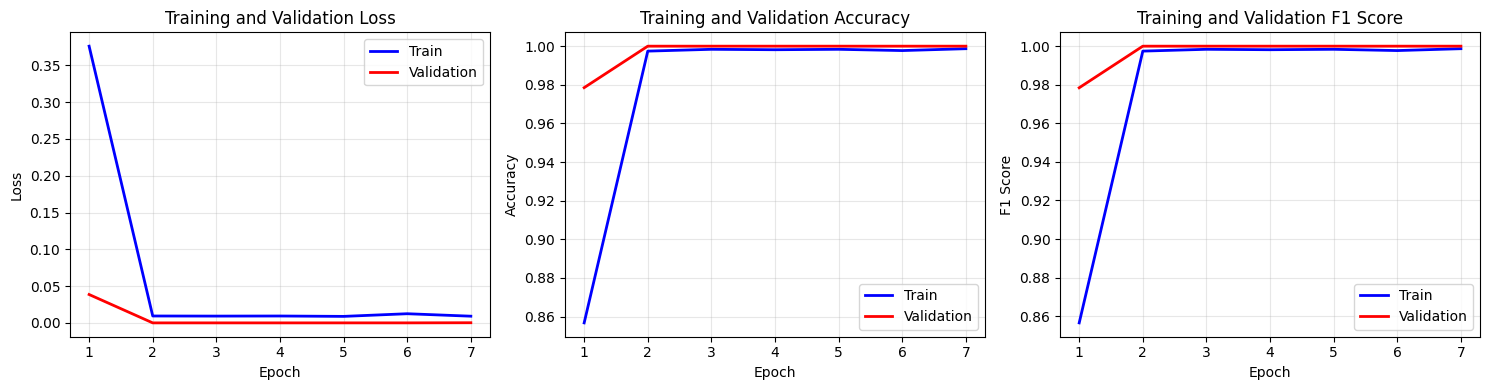

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

epochs_range = range(1, len(history['train_loss']) + 1)

axes[0].plot(epochs_range, history['train_loss'], 'b-', label='Train', linewidth=2)
axes[0].plot(epochs_range, history['val_loss'], 'r-', label='Validation', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(epochs_range, history['train_acc'], 'b-', label='Train', linewidth=2)
axes[1].plot(epochs_range, history['val_acc'], 'r-', label='Validation', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(epochs_range, history['train_f1'], 'b-', label='Train', linewidth=2)
axes[2].plot(epochs_range, history['val_f1'], 'r-', label='Validation', linewidth=2)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('F1 Score')
axes[2].set_title('Training and Validation F1 Score')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

## Evaluation

In [14]:
checkpoint = torch.load('/kaggle/working/best_model.pt', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch'] + 1}")

test_loss, test_acc, test_f1, test_preds, test_labels = evaluate(
    model, test_loader, criterion, device
)

print(f"\nTest Results:")
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {test_acc:.4f}")
print(f"F1 Score (weighted): {test_f1:.4f}")

Loaded best model from epoch 2


Evaluating:   0%|          | 0/126 [00:00<?, ?it/s]


Test Results:
Loss: 0.0080
Accuracy: 0.9990
F1 Score (weighted): 0.9990


In [15]:
print("\nClassification Report:")
target_names = [complexity_labels[i] for i in range(6)]
print(classification_report(test_labels, test_preds, target_names=target_names))


Classification Report:
              precision    recall  f1-score   support

        O(1)       1.00      1.00      1.00       668
    O(log n)       1.00      1.00      1.00       667
        O(n)       1.00      1.00      1.00       667
  O(n log n)       1.00      1.00      1.00       667
       O(n²)       1.00      1.00      1.00       667
       Other       1.00      1.00      1.00       667

    accuracy                           1.00      4003
   macro avg       1.00      1.00      1.00      4003
weighted avg       1.00      1.00      1.00      4003



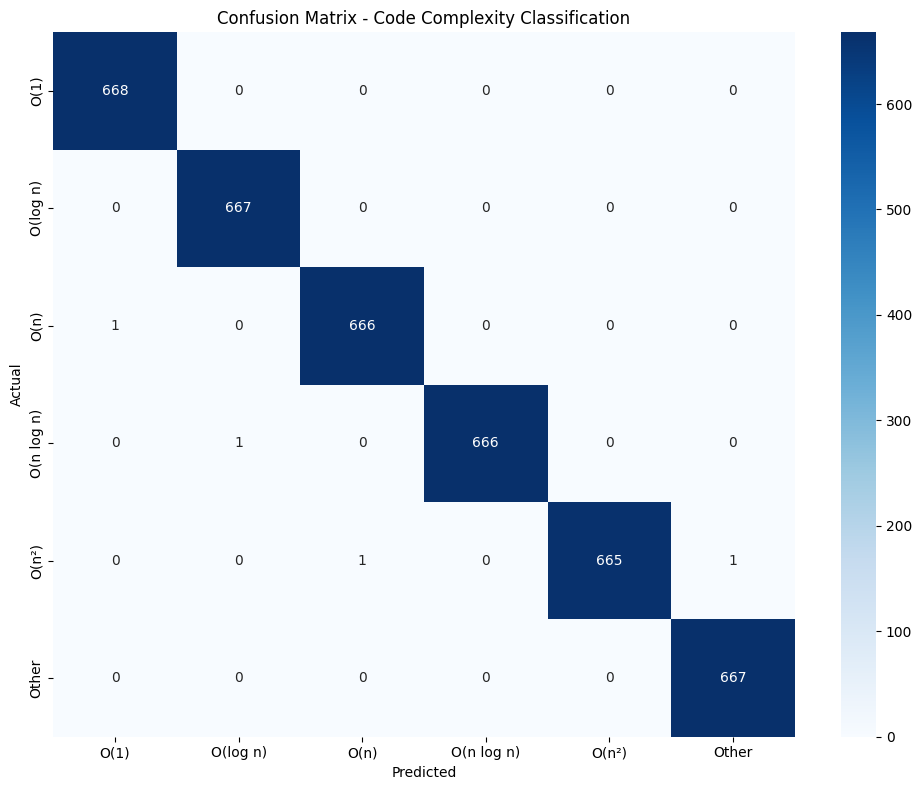

In [17]:
cm = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Code Complexity Classification')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

## 10. Inference Function

In [20]:
def predict_complexity(code: str, model, tokenizer, device) -> Tuple[str, Dict[str, float]]:
    """
    Predict the time complexity of a Python code snippet.
    
    Args:
        code: Python code as string
        model: Trained transformer model
        tokenizer: Code tokenizer
        device: torch device
    
    Returns:
        Tuple of (predicted complexity string, probability distribution)
    """
    model.eval()
    
    input_ids = tokenizer.encode(code, max_length=MAX_LENGTH)
    attention_mask = [1 if token_id != tokenizer.token2idx['<PAD>'] else 0 
                     for token_id in input_ids]

    input_ids = torch.tensor([input_ids], dtype=torch.long).to(device)
    attention_mask = torch.tensor([attention_mask], dtype=torch.long).to(device)
    
    with torch.no_grad():
        logits = model(input_ids, attention_mask)
        probs = F.softmax(logits, dim=1)[0]
        pred_class = torch.argmax(probs).item()

    prob_dict = {complexity_labels[i]: probs[i].item() for i in range(6)}
    
    return complexity_labels[pred_class], prob_dict



test_codes = [
    # O(1) - Constant
    '''
def get_first(arr):
    return arr[0] if arr else None
    ''',
    
    # O(n) - Linear
    '''
def find_max(arr):
    max_val = arr[0]
    for num in arr:
        if num > max_val:
            max_val = num
    return max_val
    ''',
    
    # O(n^2) - Quadratic
    '''
def bubble_sort(arr):
    n = len(arr)
    for i in range(n):
        for j in range(n - i - 1):
            if arr[j] > arr[j + 1]:
                arr[j], arr[j + 1] = arr[j + 1], arr[j]
    return arr
    ''',
    
    # O(log n) - Binary search
    '''
def binary_search(arr, target):
    lo, hi = 0, len(arr) - 1
    while lo <= hi:
        mid = (lo + hi) // 2
        if arr[mid] == target:
            return mid
        elif arr[mid] < target:
            lo = mid + 1
        else:
            hi = mid - 1
    return -1
    '''
]

for i, code in enumerate(test_codes):
    pred, probs = predict_complexity(code, model, tokenizer, device)
    print(f"\nCode {i + 1}:")
    print(code.strip()[:100] + "..." if len(code.strip()) > 100 else code.strip())
    print(f"\nPredicted Complexity: {pred}")
    print("Probability Distribution:")
    for complexity, prob in sorted(probs.items(), key=lambda x: -x[1])[:3]:
        print(f"  {complexity}: {prob:.2%}")


Code 1:
def get_first(arr):
    return arr[0] if arr else None

Predicted Complexity: O(1)
Probability Distribution:
  O(1): 99.99%
  O(n): 0.01%
  O(n²): 0.00%

Code 2:
def find_max(arr):
    max_val = arr[0]
    for num in arr:
        if num > max_val:
            ma...

Predicted Complexity: O(n)
Probability Distribution:
  O(n): 99.99%
  O(n²): 0.01%
  O(1): 0.00%

Code 3:
def bubble_sort(arr):
    n = len(arr)
    for i in range(n):
        for j in range(n - i - 1):
   ...

Predicted Complexity: O(n²)
Probability Distribution:
  O(n²): 100.00%
  O(1): 0.00%
  O(n log n): 0.00%

Code 4:
def binary_search(arr, target):
    lo, hi = 0, len(arr) - 1
    while lo <= hi:
        mid = (lo +...

Predicted Complexity: O(log n)
Probability Distribution:
  O(log n): 100.00%
  O(n): 0.00%
  O(1): 0.00%


## Saving model

In [21]:
import pickle

with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

torch.save({
    'model_state_dict': model.state_dict(),
    'model_config': MODEL_CONFIG,
    'complexity_labels': complexity_labels,
    'max_length': MAX_LENGTH
}, 'final_model.pt')

print("Model and tokenizer saved successfully!")

Model and tokenizer saved successfully!
